# Pulse Level Learning

In this notebook, we will train a reinforcement learning agent to learn pulse level control of a quantum system. The configuration is drawn from two dedicated yaml files respectively describing the quantum environment and the agent. The quantum environment is a `QuantumEnvironment` object, which is a subclass of `gym.Env ` and is designed to be compatible with standard RL libraries. The agent on the other hand, is specifically hard coded for our need because of the need to be able to send to the same resource (the Estimator primitive) a batch of quantum circuits (in contrast with usual RL frameworks where actions can be evaluated in parallel).

In [1]:
from template_configurations.qiskit.pulse_level.pulse_config import (
    q_env_config as pulse_q_env_config,
)
from quantumenvironment import QuantumEnvironment
from context_aware_quantum_environment import ContextAwareQuantumEnvironment
from gymnasium.wrappers import RescaleAction, ClipAction
from qiskit.circuit import QuantumCircuit
from helper_functions import simulate_pulse_schedule
from qiskit.quantum_info import Operator, Statevector
from qiskit import pulse
import numpy as np

/Users/arthurostrauss/anaconda3/envs/rl_qoc_v1/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'z', 'reset', 'rz', 'x', 't', 's', 'h', 'sx', 'id', 'sdg', 'delay', 'measure', 'tdg'}
  q1: {'z', 'reset', 'rz', 'x', 't', 's', 'h', 'sx', 'id', 'sdg', 'delay', 'measure', 'tdg'}
Multi qubit instructions:
  (0, 1): {'cr45p', 'cr45m', 'ecr'}
  (1, 0): {'cr45p', 'cr45m', 'ecr'}
)>
Circuit context: 
         ┌───┐┌─────┐     ┌──────┐┌───┐
q_0 -> 0 ┤ H ├┤ Sdg ├─────┤0     ├┤ X ├
         ├───┤└┬───┬┘┌───┐│  Ecr │└───┘
q_1 -> 1 ┤ S ├─┤ H ├─┤ S ├┤1     ├─────
         └───┘ └───┘ └───┘└──────┘     


In [2]:
q_env = QuantumEnvironment(pulse_q_env_config)
from qiskit.primitives import Estimator

# q_env = ContextAwareQuantumEnvironment(
#     gate_q_env_config, circuit_context, training_steps_per_gate=250
# )
# q_env.estimator = Estimator()
clipped_env = ClipAction(q_env)
rescaled_env = RescaleAction(clipped_env, -1.0, 1.0)

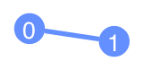

In [3]:
from qiskit.visualization import plot_gate_map

plot_gate_map(q_env.backend)

In [4]:
import yaml

with open(
        "/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/template_configurations/agent_config.yaml",
        "r",
) as f:
    agent_config = yaml.safe_load(f)

In [5]:
from ppo import make_train_ppo, CustomPPO

ppo_agent = CustomPPO(agent_config, q_env)

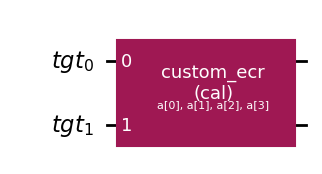

In [6]:
circuit = q_env.circuit_truncations[0]
circuit.draw("mpl")

In [7]:
circuit.calibrations

{'custom_ecr': {((0, 1),
   (ParameterVectorElement(a[0]),
    ParameterVectorElement(a[1]),
    ParameterVectorElement(a[2]),
    ParameterVectorElement(a[3]))): ScheduleBlock(ScheduleBlock(ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=1168, sigma=64, width=912, amp=a[0], angle=a[1]), ControlChannel(0)), Play(GaussianSquare(duration=1168, sigma=64, width=912, amp=a[2], angle=a[3]), DriveChannel(1)), name="cr45p", transform=AlignLeft()), ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=5.8351018416, amp=0.1188041, angle=0), DriveChannel(0)), name="x", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=1168, sigma=64, width=912, amp=a[0], angle=a[1] + 3.14159265358979), ControlChannel(0)), Play(GaussianSquare(duration=1168, sigma=64, width=912, amp=a[2], angle=a[3] + 3.14159265358979), DriveChannel(1)), name="cr45m", transform=AlignLeft()), name="block17", transform=AlignSequential()), name="ecr", transform=AlignLeft()), name="custom_sched", transform=Alig

In [8]:
ppo_agent.train(
    total_updates=300, print_debug=False, num_prints=10, clear_history=False
)

 57%|█████▋    | 170/300 [45:59<47:55, 22.12s/it]

Average gate fidelity of last gate: 0.9906588986407847
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'YI', 'YZ'],
              coeffs=[ 0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j])
Time to run simulation:  10.661624193191528
Finished Estimator job


 57%|█████▋    | 171/300 [46:11<40:47, 18.97s/it]

Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j])
Time to run simulation:  10.248825073242188
Finished Estimator job


 57%|█████▋    | 172/300 [46:22<35:31, 16.66s/it]

Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'YI', 'YZ'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


 57%|█████▋    | 172/300 [46:23<34:31, 16.18s/it]


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (18,) and (17,)

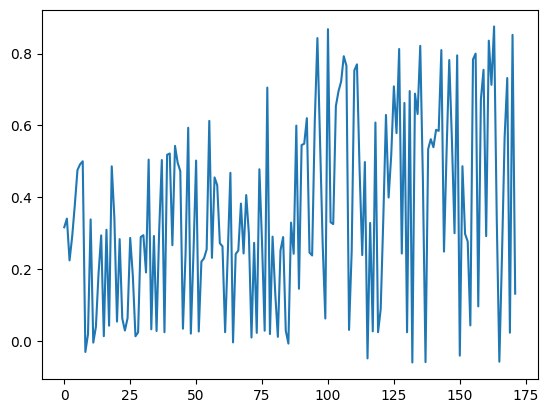

In [11]:
import matplotlib.pyplot as plt

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4
n_epochs = len(mean_rewards)
fidelity_range = np.arange(0, n_epochs, q_env.benchmark_cycle)
plt.plot(mean_rewards / 2, label=f"Mean Batch Rewards, max: {max_mean / 2}")
plt.plot(
    fidelity_range,
    np.array(q_env.avg_fidelity_history),
    label="Average Fidelity (mean over batch)",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(f"{q_env.target['gate'].name} Learning Curve")
plt.legend()
plt.show()

In [12]:
print("Optimal action", q_env.optimal_action)
print("Best fidelity:", np.max(q_env.avg_fidelity_history))

Optimal action [ 0.1316062  -0.2860792   0.97280544  0.34839156]
Best fidelity: 1.041397428216173


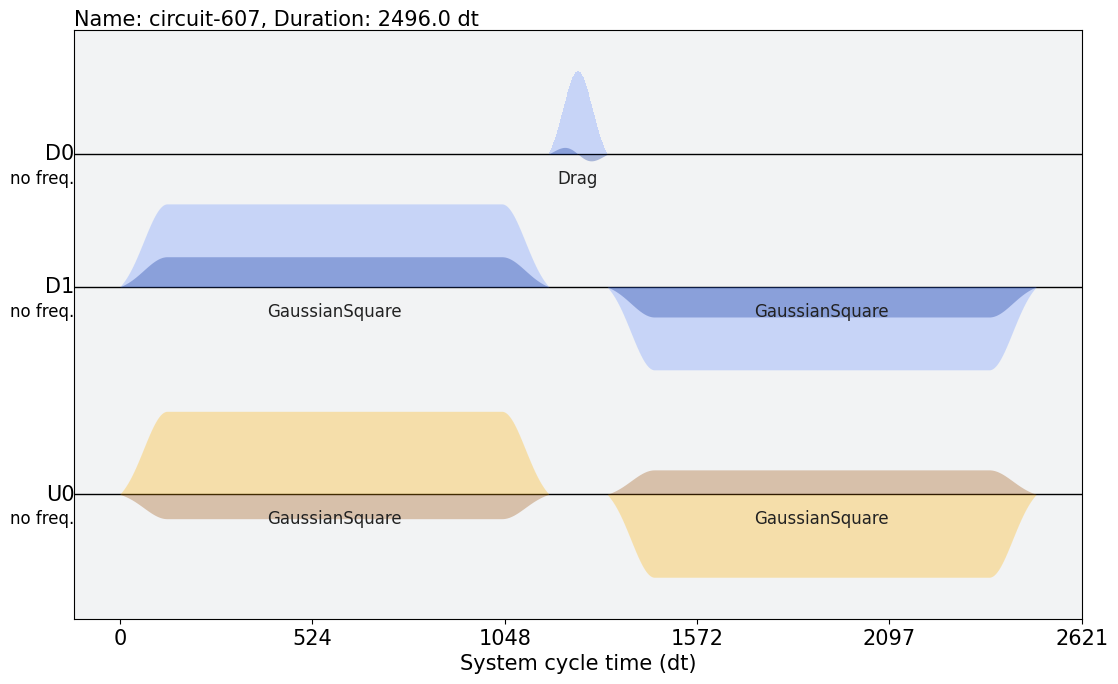

In [13]:
# Update the gate calibration in the backend target and retrieve the calibration
optimal_calibration = q_env.update_gate_calibration()
q_env.backend.target.get_calibration("ecr", (0, 1)).draw()

In [14]:
from helper_functions import simulate_pulse_schedule
from qiskit.circuit.library import CXGate, HGate, RZGate, ECRGate
from qiskit.quantum_info import average_gate_fidelity, Operator, Statevector

data = simulate_pulse_schedule(
    q_env.backend,
    optimal_calibration,
    target_unitary=Operator(ECRGate()),
)

print(data)

{'unitary': Operator([[ 2.16534545e-01+1.00580903e-01j,
           -2.86648717e-01+5.23475215e-01j,
           -4.85594570e-03-7.68448319e-03j,
           -6.14098670e-02-2.99386139e-02j,
           -5.60897189e-01-6.96371908e-01j,
           -1.53131006e-03+3.29666658e-04j,
           -1.60779169e-02-1.94101385e-02j,
           -1.01245974e-03-8.37158374e-03j,
            4.79401192e-04+5.86225160e-04j],
          [ 1.16008460e-02+6.25468437e-01j,
            7.95285478e-02-1.09161805e-02j,
           -1.24570433e-03-5.97419474e-04j,
            8.43542774e-01+3.07252418e-01j,
           -1.07148667e-01+5.07797512e-02j,
           -5.07966399e-04+5.46406321e-04j,
           -3.12250955e-03+6.11153300e-03j,
           -2.39002397e-03-2.11269366e-03j,
            6.21969032e-05-3.46045285e-05j],
          [ 7.38055333e-03+8.97643952e-03j,
            3.52069569e-03+2.86368625e-03j,
           -6.41550537e-01+8.90895620e-01j,
           -6.93307316e-03+3.87327325e-03j,
            8.8623

In [62]:
# Testing gate in a quantum circuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit import transpile

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
qc.draw("mpl")

basic_simulator = BasicSimulator()
basic_result = basic_simulator.run(qc).result()

pulse_circ = transpile(qc, q_env.backend)
q_env.backend.options.shots = 10000
pulse_results = q_env.backend.run(pulse_circ).result()

print("BasicProvider: ", basic_result.get_counts())
print("Custom Backend:", pulse_results.get_counts())

BasicProvider:  {'00': 517, '11': 507}
Custom Backend: {'00': 5752, '01': 309, '10': 1200, '11': 2739}


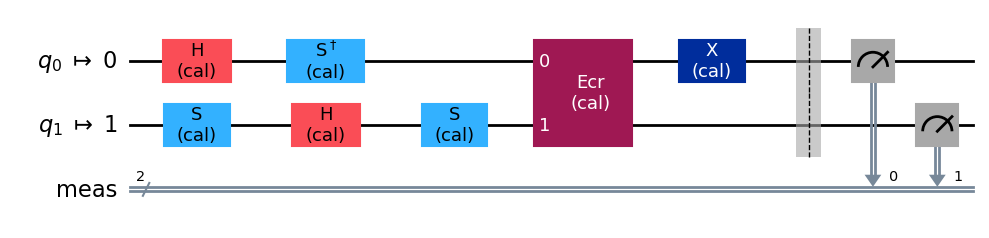

In [63]:
pulse_circ.draw("mpl")

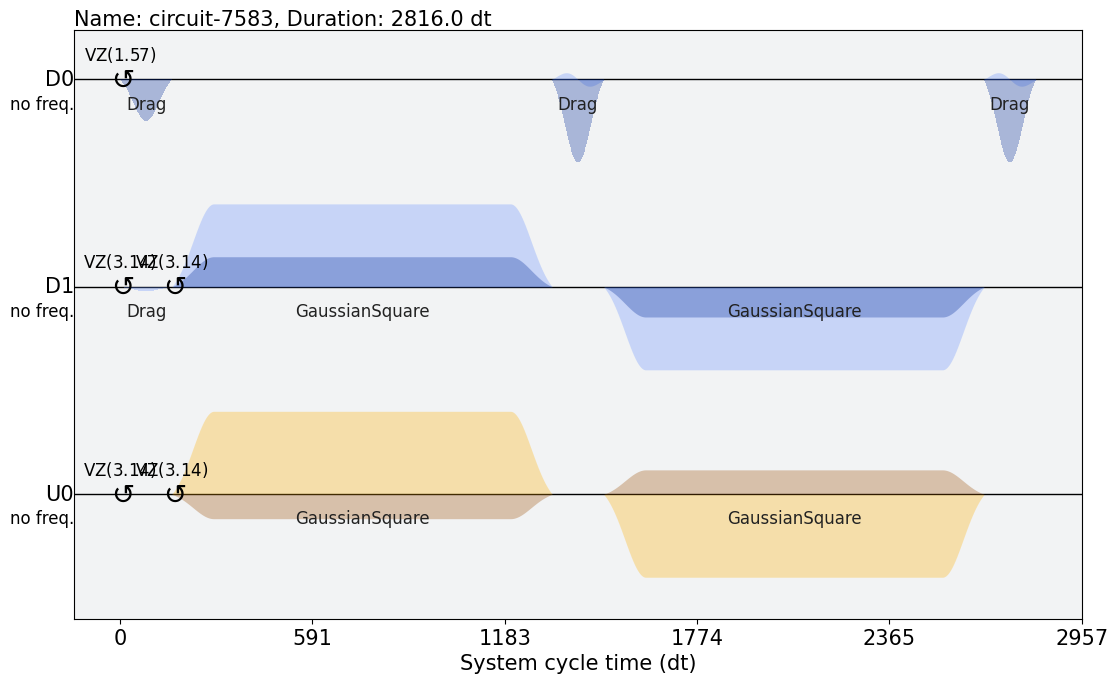

In [64]:
# Testing the pulse schedule
from qiskit import schedule

pulse_schedule = schedule(
    pulse_circ.remove_final_measurements(inplace=False), q_env.backend
)
pulse_schedule.draw()

In [66]:
# Testing the pulse schedule
pulse_sim_results = simulate_pulse_schedule(
    q_env.backend,
    pulse_schedule,
    target_unitary=Operator(pulse_circ.remove_final_measurements(inplace=False)),
    target_state=(Statevector.from_label("00") + Statevector.from_label("11"))
                 / np.sqrt(2),
)
print(pulse_sim_results)

{'unitary': Operator([[ 6.20708878e-01+5.53604128e-01j,
           -5.38238281e-01-3.74265765e-01j,
           -1.76700823e-03-4.87676648e-04j,
            2.46078942e-01-5.31373094e-02j,
           -1.08898579e-01+5.80029029e-02j,
           -2.06442206e-05+9.27514202e-04j,
           -5.89983637e-03+1.06359766e-03j,
            7.77087616e-04+4.04301002e-05j,
            5.71008770e-05-1.37076139e-04j],
          [-9.16351238e-03-2.01752553e-01j,
           -2.34897052e-01-3.47420060e-02j,
           -2.47363261e-03+6.36862510e-03j,
            3.23726959e-03+9.59566426e-01j,
           -3.03130815e-02+4.26316131e-01j,
            5.87255700e-03-8.00265797e-04j,
            4.82115429e-04+7.05224378e-03j,
           -4.61764153e-03-3.11362604e-03j,
            8.85706897e-05-3.52020647e-04j],
          [-4.12933008e-03+6.72184296e-03j,
           -7.80006624e-03+6.56806527e-03j,
           -4.95447723e-01+6.33872644e-01j,
           -7.15075146e-03+1.61883057e-03j,
            5.1894

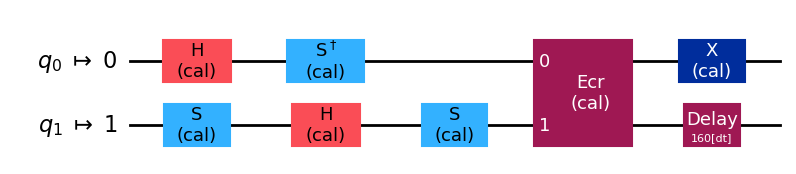

In [75]:
new_circ = transpile(
    pulse_circ.remove_final_measurements(inplace=False),
    q_env.backend,
    scheduling_method="asap",
)
new_circ.draw("mpl")

In [77]:
new_circ.op_start_times

[0, 160, 0, 0, 160, 160, 2656, 2656]

In [80]:
instruction_list = []
for instruction in new_circ.data:
    instruction_list.append(instruction.operation.name)
instruction_list

['h', 'sdg', 's', 'h', 's', 'ecr', 'x', 'delay']